<a href="https://colab.research.google.com/github/MarianiPedro/topicos_especiais_ANN/blob/main/MLP_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier


def sigmoid(z): return 1 / (1 + np.exp(-z))
def dsigmoid(z): s = sigmoid(z); return s * (1 - s)

def relu(z): return np.maximum(0, z)
def drelu(z): return (z > 0).astype(float)

def leaky_relu(x): return np.where(x > 0, x, 0.01 * x)
def dleaky_relu(x): return np.where(x > 0, 1, 0.01)

def tanh(z): return np.tanh(z)
def dtanh(z): return 1 - np.tanh(z) ** 2

activations_functinos = {
    'sigmoid': (sigmoid, dsigmoid),
    'relu': (relu, drelu),
    'tanh': (tanh, dtanh),
    'leaky_relu': (leaky_relu, dleaky_relu)
}


In [ ]:
# aceitar parâmetros para definir a quantidade de camadas,
# quantidade de neurônios em cada camada
# função de ativação que será utilizada em cada camada.
class MLP:
    def __init__(self, layer_sizes, activations_list, learning_rate=0.1, epochs=1000):
        self.layer_sizes = layer_sizes
        self.activations_list = activations_list
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = []
        self.biases = []
        self.loss_history = []
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.1)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward(self, X):
        a = X
        activations = [X]
        zs = []
        for i in range(len(self.weights)):
            z = a @ self.weights[i] + self.biases[i]
            a = activations_functinos[self.activations_list[i]][0](z)
            zs.append(z)
            activations.append(a)
        return activations, zs

    def backward(self, X, y, activations, zs):
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)

        delta = (activations[-1] - y) * activations_functinos[self.activations_list[-1]][1](zs[-1])
        grads_w[-1] = activations[-2].T @ delta
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

        for l in range(len(self.weights) - 2, -1, -1):
            delta = (delta @ self.weights[l+1].T) * activations_functinos[self.activations_list[l]][1](zs[l])
            grads_w[l] = activations[l].T @ delta
            grads_b[l] = np.sum(delta, axis=0, keepdims=True)

        return grads_w, grads_b

    def update_params(self, grads_w, grads_b, m):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i] / m
            self.biases[i] -= self.learning_rate * grads_b[i] / m

    def train(self, X, y):
      for epoch in range(self.epochs):
          activations, zs = self.forward(X)
          grads_w, grads_b = self.backward(X, y, activations, zs)
          self.update_params(grads_w, grads_b, X.shape[0])

          loss = np.mean((activations[-1] - y)**2)
          self.loss_history.append(loss)

          if epoch % 100 == 0:
              print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return (activations[-1] > 0.5).astype(int)

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
layers = [2, 10, 8, 1]
activations = ['tanh', 'tanh', 'sigmoid', 'leaky_relu']

mlp = MLP(layer_sizes=layers, activations_list=activations, learning_rate=0.1, epochs=1000)
mlp.train(X_train, y_train)

y_pred = mlp.predict(X_test)
acc_custom = accuracy_score(y_test, y_pred)
print(f"Acurácia (MLP Customizado): {acc_custom:.4f}")

Epoch 0, Loss: 0.2474
Epoch 100, Loss: 0.2054
Epoch 200, Loss: 0.1345
Epoch 300, Loss: 0.1043
Epoch 400, Loss: 0.0950
Epoch 500, Loss: 0.0927
Epoch 600, Loss: 0.0925
Epoch 700, Loss: 0.0929
Epoch 800, Loss: 0.0938
Epoch 900, Loss: 0.0951
Acurácia (MLP Customizado): 0.8450


In [ ]:
sk_mlp = MLPClassifier(hidden_layer_sizes=(10, 8), activation='tanh', max_iter=1000, random_state=42)
sk_mlp.fit(X_train, y_train.ravel())

y_pred_sk = sk_mlp.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred_sk)
print(f"Acurácia (Scikit-Learn): {acc_sk:.4f}")

Acurácia (Scikit-Learn): 0.9850


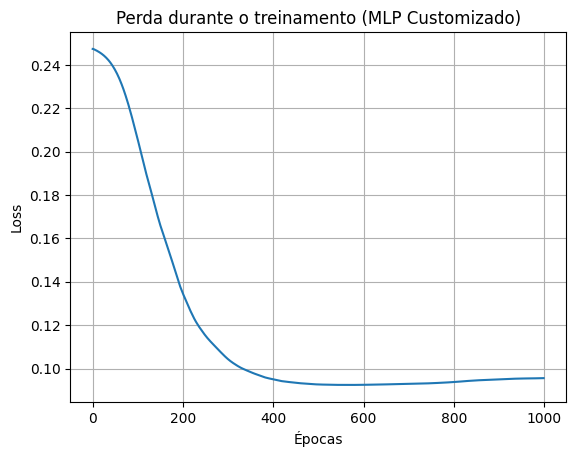

In [ ]:
plt.plot(mlp.loss_history)
plt.title("Perda durante o treinamento (MLP Customizado)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

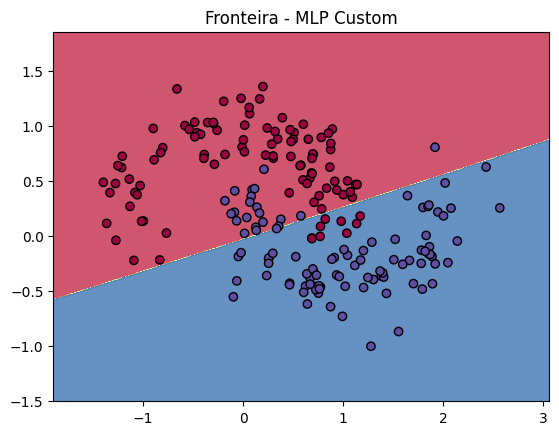

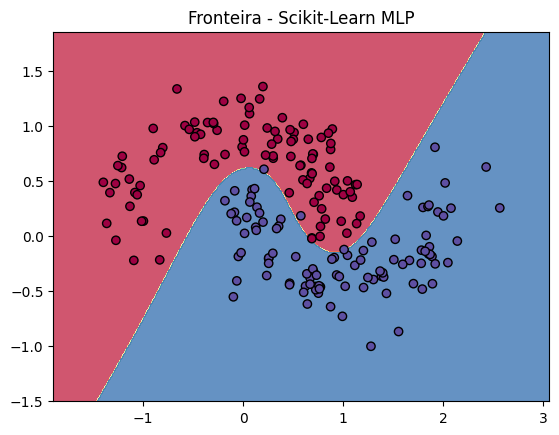

In [ ]:
def plot_decision_boundary(model, X, y, title):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.Spectral, edgecolors='k')
    plt.title(title)
    plt.show()

plot_decision_boundary(mlp, X_test, y_test, "Fronteira - MLP Custom")
plot_decision_boundary(sk_mlp, X_test, y_test, "Fronteira - Scikit-Learn MLP")